In [1]:
import re
import os
import glob
import csv
import datetime
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Select Patients Treated w/ vasodilators/vasoconstrictors from MIMIC II (Multiparameter Intelligent Monitoring in Intensive Care) Clinical Database

MIMIC II Clinical database: (https://physionet.org/works/MIMICIIClinicalDatabase/files/)

MIMIC II Waveform Matched Subset database (550 GB): (https://www.physionet.org/physiobank/database/mimic2wdb/matched/).

For each of the patient (there are 3000+ of patients), there are multiple text files. 

**Files of interest:**

* MEDEVENTS
* ADDITIVES
* PEO_MED
* POE_ORDER
* DEMOGRAPHIC_DETAIL.

**Medications of interest:**

1. vasodilators:
    * nitroglycerine-k (121)
    * nitroglycerine (49)
    * nitroprussid (50)
2. vasoconstrictors: 
    * neosynephrine-k (128)
    * epinephrine-k (119)
    * neosyneprine (127)
    * epinephrine drip (309)
    * dobutamine (42)
    * epinephrine (44)

It's better to search the name of all the interested drugs in the file POE_MED or POE_ORDER

In [2]:
POE_MED = glob.glob("./data/00/*/POE_MED*")
POE_ORDER = glob.glob("./data/00/*/POE_ORDER*")

In the MEDEVENTS file, the drugs are represented by the codes in the parethesis.

In [3]:
MEDEVENTS = glob.glob("./data/00/*/MEDEVENTS*")

For each of the patient treated with either vasodilators or vasoconstrictors, we may need to merge those files together at a later stage. For example, we merge POE_MED with POE_ORDER to get the duration and dose of nitroglycerine in one file, after we decide to pick the record of specific patient. We can discuss about this merge when we meet next time.

### Function to read and merge clinical data CSVs

In [4]:
def read_csvs(file_list):
    data = []
    header_saved = False
    for file in file_list:
        # skip empty files
        if os.stat(file).st_size != 0:
            with open(file, 'r') as f:
                reader = csv.reader(f)
                header = ['DIR_NAME'] + next(reader, None)
                # keep only the first header
                if not header_saved:
                    data.append(header)
                    header_saved = True
                for line in reader:
                    fname = file.split('/')[3]
                    data.append([fname] + line)
    return data

In [5]:
drugs = read_csvs(POE_MED)
medev = read_csvs(MEDEVENTS)
orders = read_csvs(POE_ORDER)

df_orders = pd.DataFrame(orders[1:], columns=orders[0])
df_medev = pd.DataFrame(medev[1:], columns=medev[0])
df_drugs = pd.DataFrame(drugs[1:], columns=drugs[0])

### Filter by drugs of interest

In [6]:
vasodilators = '|'.join(['nitroglycerin', 'nitroprussid'])
vasoconstrictors = '|'.join(['neosynephrine', 'epinephrine', 'neosyneprine', 'epinephrine drip', 'dobutamine', 'dobutamine'])

vasoconstrictor_index = df_drugs.DRUG_NAME_GENERIC.str.contains(vasoconstrictors, case=False)
vasodilator_index = df_drugs.DRUG_NAME_GENERIC.str.contains(vasodilators, case=False)

df_vasoconstrictor = df_drugs[vasoconstrictor_index]
df_vasodilator = df_drugs[vasodilator_index]

# 2. Merge clinical data with MIMIC II Wafeform Matched Subset

The next task is to merge the selected clinical data with the MIMIC II Waveform Matched Subset. This is free access, but very large if we wish to download all. The description page has some codes for downloading, but I don't know if you can expand the code to add some query. 

To visualize the waveform data, you can go to [PhysioNet ATM](https://www.physionet.org/cgi-bin/atm/ATM) and go to the Input database drop down menu and click MIMIC II Waveform Matched Subset (mimic2wdb/matched) and choose the samples in the below drop down menu. To merge the subset with the clinical data, I believe there is a subject_id that is shared by both. I was told we also need to align the time of different data files. Yes, the cleanup itself is a lot of work!

### Download waveform record names that have been matched with clinical records

In [7]:
# RECORDS_waveforms = 'https://www.physionet.org/physiobank/database/mimic2wdb/matched/RECORDS-waveforms'

# with urllib.request.urlopen(RECORDS_waveforms) as response:
#    html = response.readlines()

# with open('RECORDS_waveforms.txt', 'w') as f:
#     for line in html:
#         f.write(str(line)[2:-3] + '\n')

In [8]:
RECORDS_waveforms = open('./data/RECORDS_waveforms.txt', 'r').readlines()
matched_waveform_codes = [x.split('/')[0][1:] for x in RECORDS_waveforms]

### Filter patients that have waveform data available that also had a vasoconstrictor/vasodilator

In [9]:
df_vasoconstrictor[df_vasoconstrictor.DIR_NAME.isin(matched_waveform_codes)]

,DIR_NAME,POE_ID,DRUG_TYPE,DRUG_NAME,DRUG_NAME_GENERIC,PROD_STRENGTH,FORM_RX,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,DOSE_VAL_DISP,DOSE_UNIT_DISP,DOSE_RANGE_OVERRIDE
11745,00177,1080930,MAIN,Lidocaine 0.5%/Epinephrine,Lidocaine 0.5%/Epinephrine,50ML VIAL,,1,ml,1,VIAL,,,
25285,00402,4696794,MAIN,Lidocaine 1%/Epinephrine 1:100000,Lidocaine 1%/Epinephrine 1:100000,20mL Vial,,5,ml,0.25,VIAL,,,


In [10]:
df_vasodilator[df_vasodilator.DIR_NAME.isin(matched_waveform_codes)]

,DIR_NAME,POE_ID,DRUG_TYPE,DRUG_NAME,DRUG_NAME_GENERIC,PROD_STRENGTH,FORM_RX,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,DOSE_VAL_DISP,DOSE_UNIT_DISP,DOSE_RANGE_OVERRIDE
11692,00177,1011023,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.4MG SL TAB,,0.4,mg,1,TAB,,,
11693,00177,1011024,MAIN,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,30g Tube,,1,in,0.01,TUBE,,,
20836,00328,93149,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,TAB,0.3,mg,1,TAB,.30000001192092896,mg,
23440,00368,663618,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,,0.3,mg,1,TAB,,,
27612,00427,345299,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,TAB,0.3,mg,1,TAB,.30000001,mg,
31967,00491,429759,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,TAB,0.3,mg,1,TAB,.30000001,mg,
42230,00682,1647112,MAIN,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,1 gm Packet,,1,in,1,PKT,,,
43537,00703,534862,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,TAB,0.3,mg,1,TAB,.30000001,mg,
50704,00801,4043858,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3mg SL Tablet Bottle,,0.3,mg,1,TAB,,,
55505,00894,841595,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,,0.3,mg,1,TAB,,,


### Example code to generate waveform output for record 00177

You'll need to install [WFDB software](https://physionet.org/physiotools/wfdb-linux-quick-start.shtml) in order to call these functions. I just created a VM using the Vagrantfile in current directory.

    rdsamp -r mimic2wdb/matched/s00177/s00177-3299-12-03-12-35 -c -H -f 0 -t 60 -v -pd > 00177_samples.csv

In [11]:
df_samples_00177 = pd.read_csv('./data/00177_samples.csv')

In [12]:
df_samples_00177.columns = ['time_date', 'II', 'MCL1', 'ABP']

In [13]:
df_samples_00177.head()

,time_date,II,MCL1,ABP
0,'hh:mm:ss.mmm dd/mm/yyyy','mV','mV','mmHg'
1,'[12:35:33.833 03/12/3299]',-0.053,-0.053,68.000
2,'[12:35:33.841 03/12/3299]',-0.053,-0.053,68.000
3,'[12:35:33.849 03/12/3299]',-0.039,-0.053,67.200
4,'[12:35:33.857 03/12/3299]',-0.039,-0.053,67.200


In [14]:
df_samples_00177 = df_samples_00177.loc[1:].reset_index(drop=True)

In [15]:
df_samples_00177.time_date = df_samples_00177.time_date.apply(lambda x: datetime.datetime.strptime(x, "\'[%H:%M:%S.%f %m/%d/%Y]\'"))

In [16]:
df_samples_00177.ABP = df_samples_00177.ABP.astype('float')
df_samples_00177.II = df_samples_00177.II.astype('float')
df_samples_00177.MCL1 = df_samples_00177.MCL1.astype('float')

In [17]:
# rewrite year to 2000 b/c pandas complained
df_samples_00177.index = df_samples_00177.time_date.apply(lambda x: x.replace(year=2000))

In [18]:
df_samples_00177.head()

,time_date,II,MCL1,ABP
time_date,,,,
2000-03-12 12:35:33.833,3299-03-12 12:35:33.833000,-0.053,-0.053,68.0
2000-03-12 12:35:33.841,3299-03-12 12:35:33.841000,-0.053,-0.053,68.0
2000-03-12 12:35:33.849,3299-03-12 12:35:33.849000,-0.039,-0.053,67.2
2000-03-12 12:35:33.857,3299-03-12 12:35:33.857000,-0.039,-0.053,67.2
2000-03-12 12:35:33.865,3299-03-12 12:35:33.865000,-0.053,-0.053,66.4


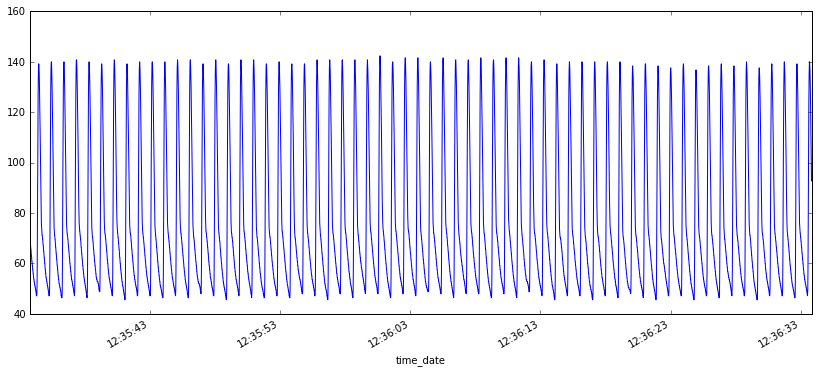

In [19]:
df_samples_00177.ABP.plot(figsize=(14,6))